In [10]:
import torch # type: ignore

if __name__ == "__main__":
    print(torch.__version__)
    # Setup device agnostic code
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

2.0.1+cu118
Using device: cuda


In [11]:
import torch


class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.linear1 = torch.nn.Linear(100, 200)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(200, 10)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x


tinymodel = TinyModel()

print('The model:')
print(tinymodel)

print('\n\nJust one layer:')
print(tinymodel.linear2)

print('\n\nModel params:')
for param in tinymodel.parameters():
    print(param)

print('\n\nLayer params:')
for param in tinymodel.linear2.parameters():
    print(param)

The model:
TinyModel(
  (linear1): Linear(in_features=100, out_features=200, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=200, out_features=10, bias=True)
  (softmax): Softmax(dim=None)
)


Just one layer:
Linear(in_features=200, out_features=10, bias=True)


Model params:
Parameter containing:
tensor([[-0.0708, -0.0851,  0.0290,  ...,  0.0032, -0.0527,  0.0193],
        [ 0.0232, -0.0486,  0.0378,  ..., -0.0408,  0.0732, -0.0149],
        [ 0.0373,  0.0352, -0.0231,  ...,  0.0403, -0.0399, -0.0527],
        ...,
        [ 0.0759,  0.0617, -0.0757,  ..., -0.0038,  0.0693, -0.0414],
        [-0.0157,  0.0224,  0.0283,  ...,  0.0580, -0.0439,  0.0638],
        [ 0.0731, -0.0434,  0.0294,  ...,  0.0854,  0.0757, -0.0095]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0284,  0.0284, -0.0258, -0.0305,  0.0641, -0.0005,  0.0453,  0.0070,
         0.0833, -0.0531,  0.0888, -0.0586,  0.0956, -0.0037, -0.0676, -0.0806,
        -0.0609,  0.0648,  0.0021,  0.06

In [12]:
import torch.nn.functional as F


class LeNet(torch.nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = torch.nn.Conv2d(1, 6, 5)
        self.conv2 = torch.nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = torch.nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [13]:
from torch import nn  # type: ignore
import torch.nn.functional as F # type: ignore


class MySmallModel(nn.Module):
    def __init__(self):
        super(MySmallModel, self).__init__()
        self.fc1 = nn.Linear(5, 2)
        self.fc2 = nn.Linear(2, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.network1 = MySmallModel()
        self.network2 = MySmallModel()
        self.network3 = MySmallModel()

        self.fc1 = nn.Linear(3, 2)
        self.fc_out = nn.Linear(2, 1)

    def forward(self, x1, x2, x3):
        x1 = F.relu(self.network1(x1))
        x2 = F.relu(self.network2(x2))
        x3 = F.relu(self.network3(x3))

        x = torch.cat((x1, x2, x3), 1)
        x = F.relu(self.fc1(x))
        x = self.fc_out(x)
        return x


model = MyModel()
N = 10
x1, x2, x3 = torch.randn(N, 5), torch.randn(N, 5), torch.randn(N, 5)

output = model(x1, x2, x3)

## Sparse Model Validation 

### Parameterisation of Feature Size and Group Feature Size

In [14]:
class GroupLayer(nn.Module):
    def __init__(self, group_feat_size: int):
        super(GroupLayer, self).__init__()
        self.fc1 = nn.Linear(group_feat_size, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x 

class TorchModel(nn.Module):
    def __init__(self, group_feat_size: int, total_feat_size: int):
        super(TorchModel, self).__init__()
        self.group_feat_size = group_feat_size
        self.total_feat_size = total_feat_size
        num_groups = self.total_feat_size // self.group_feat_size
        # if num_groups not an integer, throw error
        if num_groups != self.total_feat_size / self.group_feat_size:
            raise ValueError("Total feature size must be divisible by group feature size")
        
        self.num_groups = num_groups
        self.group_layers = nn.ModuleList()
        i = 0 
        while i < num_groups:
            self.group_layers.append(GroupLayer(group_feat_size))
            i += 1
            
        self.layer_2_size = int(num_groups / 2)
        
        self.fc1 = nn.Linear(num_groups, self.layer_2_size)
        self.fc_out = nn.Linear(self.layer_2_size, 1)
        

    def forward(self, input_data):
        # print(input_data.shape)
        xs = []
        i = 0
        while i < self.total_feat_size:
            xs.append(input_data[:, i:i+self.group_feat_size])
            i += group_feat_size
        
        outs = []
        for i,x in enumerate(xs):
            # print(i+1, x.shape)
            outs.append(self.group_layers[i](x))

        x = torch.cat(outs, 1)
        x = F.relu(self.fc1(x))
        x = self.fc_out(x)
        return x
    

group_feat_size = 10
total_feat_size = 260

model = TorchModel(group_feat_size, total_feat_size)
N = 10
x = torch.randn(N, total_feat_size)
output = model(x)
print(output)
print(model)

tensor([[-0.2135],
        [-0.1285],
        [-0.2141],
        [-0.1349],
        [-0.0851],
        [-0.0523],
        [-0.2534],
        [-0.2638],
        [-0.0889],
        [-0.2055]], grad_fn=<AddmmBackward0>)
TorchModel(
  (group_layers): ModuleList(
    (0-25): 26 x GroupLayer(
      (fc1): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (fc1): Linear(in_features=26, out_features=13, bias=True)
  (fc_out): Linear(in_features=13, out_features=1, bias=True)
)


### Model Optimisation Validation 

In [15]:
# use sklearn to generate some regression data

from torch.utils.data import DataLoader
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=10000, n_features=260, noise=0.1)
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

train_dl = DataLoader(list(zip(X_train, y_train)), batch_size=32, shuffle=True)
test_dl = DataLoader(list(zip(X_test, y_test)), batch_size=32, shuffle=False)

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

model = TorchModel(group_feat_size, total_feat_size)


In [19]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# criterion = torch.nn.MSELoss()

# def train(model, train_dl, optimizer, criterion, epochs=10):
#     running_loss = 0.0
#     for epoch in range(epochs):
#         print(f"### Epoch {epoch}")
#         for i, (x, y) in enumerate(train_dl):
#             optimizer.zero_grad()
#             output = model(x)
#             loss = criterion(output, y)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#             print(f"Batch {i} loss: {loss.item()}")
            
#     return running_loss / len(train_dl)
                            

# train(model, train_dl, optimizer, criterion)

In [20]:
# # plot the output against the target

# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(4, 4))
# plt.scatter(y_test, output.detach().numpy())
# plt.xlabel('True Value')
# plt.ylabel('Predicted Value')
# plt.title('Predicted vs True Value')
# plt.show()

### Trying skorch

In [21]:
from skorch import NeuralNetRegressor
from torch import nn  # type: ignore
import torch.nn.functional as F  # type: ignore

class GroupLayer(nn.Module):

    def __init__(self, group_feat_size: int):
        super(GroupLayer, self).__init__()
        self.fc1 = nn.Linear(group_feat_size, 1).double()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x

class TorchModel(nn.Module):

    def __init__(self, group_feat_size: int, total_feat_size: int):

        super(TorchModel, self).__init__()
        self.group_feat_size = group_feat_size
        self.total_feat_size = total_feat_size

        num_groups = self.total_feat_size // self.group_feat_size

        # if num_groups not an integer, throw error
        if num_groups != self.total_feat_size / self.group_feat_size:
            raise ValueError("Total feature size must be divisible by group feature size")

        self.num_groups = num_groups
        self.group_layers = nn.ModuleList()
        i = 0
        while i < num_groups:
            self.group_layers.append(GroupLayer(group_feat_size))
            i += 1
        self.layer_2_size = int(num_groups / 2)
        self.fc1 = nn.Linear(num_groups, self.layer_2_size).double()
        self.fc_out = nn.Linear(self.layer_2_size, 1).double()


    def forward(self, input_data):

        # print(input_data.shape)

        xs = []
        i = 0
        while i < self.total_feat_size:
            xs.append(input_data[:, i:i+self.group_feat_size])
            i += group_feat_size


        outs = []
        for i, x in enumerate(xs):
            # print(i+1, x.shape)
            outs.append(self.group_layers[i](x))


        x = torch.cat(outs, 1)
        x = F.relu(self.fc1(x))
        x = self.fc_out(x)
        return x



group_feat_size = 10
total_feat_size = 260

net = NeuralNetRegressor(
    TorchModel,
    module__group_feat_size=group_feat_size,
    module__total_feat_size=total_feat_size,
    optimizer=torch.optim.Adam,
    criterion=torch.nn.MSELoss,
    max_epochs=20,
    lr=0.001,
    batch_size=32,
    iterator_train__shuffle=True
)


In [22]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=2000, n_features=260, noise=0.01)
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    36538.5951    30354.4184  0.2810
      2    36533.6516    30353.1917  0.2420
      3    36528.3852    30350.3127  0.2340
      4    36519.5394    30346.8352  0.2270
      5    36506.7564    30339.8095  0.2300
      6    36483.1964    30326.1093  0.2260
      7    36442.3965    30300.9058  0.2287
      8    36373.7734    30250.7520  0.2210
      9    36253.8789    30159.9985  0.2340
     10    36048.8307    30005.9318  0.2310
     11    35733.6286    29758.5801  0.2420
     12    35277.7611    29411.6200  0.2330
     13    34664.7881    28955.0099  0.2320
     14    33879.7537    28352.6917  0.2270
     15    32897.6194    27620.7411  0.2228
     16    31736.0332    26750.7767  0.2350
     17    30372.7937    25785.9721  0.2270
     18    28853.6752    24630.6073  0.2240
     19    27153.0052    23415.5359  0.2270
     20    25371.6254    22117.3457  0.2370


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=TorchModel(
    (group_layers): ModuleList(
      (0-25): 26 x GroupLayer(
        (fc1): Linear(in_features=10, out_features=1, bias=True)
      )
    )
    (fc1): Linear(in_features=26, out_features=13, bias=True)
    (fc_out): Linear(in_features=13, out_features=1, bias=True)
  ),
)

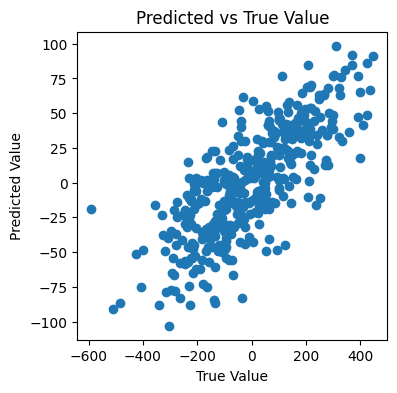

In [24]:
# make prediction 

y_pred = net.predict(X_test)

# plot the output against the target

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred)
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Predicted vs True Value')
plt.show()

In [25]:
# test pearson correlation 

# calculate pearson correlation

from scipy.stats import pearsonr

corr, _ = pearsonr(y_test.flatten(), y_pred.flatten())

print(f'Pearsons correlation: {corr}')

Pearsons correlation: 0.7669682676823475


## Data Integration Validation 

### Initialisation

In [26]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')
# Bring in CCLE data


Project path set to: c:\Github\ode-biomarker-project


In [27]:
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')


In [28]:
# load in original ccle data
loading_code = 'generic-gdsc-1-FGFR_0939-LN_IC50-fgfr4_ccle_dynamic_features_v2-true-Unnamed: 0'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
feature_data, label_data = data_link.get_data_using_code(loading_code)

In [29]:
feature_data

,pIGFR_auc,pIGFR_median,pIGFR_tfc,pIGFR_tmax,pIGFR_max,pIGFR_tmin,pIGFR_min,pIGFR_ttsv,pIGFR_tsv,pIGFR_init,...,amTORC2_auc,amTORC2_median,amTORC2_tfc,amTORC2_tmax,amTORC2_max,amTORC2_tmin,amTORC2_min,amTORC2_ttsv,amTORC2_tsv,amTORC2_init
SIDM01085,0.019410,0.021032,4.682872,0.96,0.032885,0.0,0.005787,0.04,0.005787,0.005787,...,0.001717,0.001599,5.486629,0.96,0.003834,0.00,0.000591,0.04,0.000591,0.000591
SIDM00949,0.077292,0.084704,9.089875,0.96,0.140803,0.0,0.013955,0.04,0.013955,0.013955,...,0.218305,0.226915,0.364546,0.96,0.264206,0.00,0.193622,0.04,0.193622,0.193622
SIDM00494,0.010086,0.011210,3.560627,0.96,0.015136,0.0,0.003319,0.04,0.003319,0.003319,...,0.019850,0.020458,0.403167,0.96,0.024825,0.00,0.017692,0.04,0.017692,0.017692
SIDM00377,0.036978,0.039602,5.138051,0.96,0.065341,0.0,0.010645,0.04,0.010645,0.010645,...,0.000361,0.000332,1.189183,0.96,0.000639,0.00,0.000292,0.04,0.000292,0.000292
SIDM00988,0.027368,0.030932,8.449997,0.96,0.039991,0.0,0.004232,0.04,0.004232,0.004232,...,0.008990,0.009058,0.465354,0.96,0.011839,0.08,0.008078,0.04,0.008079,0.008079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM00697,0.013521,0.014763,9.576674,0.96,0.024837,0.0,0.002348,0.04,0.002348,0.002348,...,0.000116,0.000116,0.539425,0.96,0.000160,0.00,0.000104,0.04,0.000104,0.000104
SIDM01188,0.032034,0.036092,11.164995,0.96,0.056863,0.0,0.004674,0.04,0.004674,0.004674,...,0.140425,0.146074,0.332654,0.96,0.167943,0.00,0.126022,0.04,0.126022,0.126022
SIDM00999,0.015288,0.016662,5.579325,0.96,0.026040,0.0,0.003958,0.04,0.003958,0.003958,...,0.002991,0.002788,4.879114,0.96,0.006578,0.00,0.001119,0.04,0.001119,0.001119
SIDM00149,0.078582,0.089001,14.430451,0.96,0.135102,0.0,0.008756,0.04,0.008756,0.008756,...,0.142652,0.147998,0.297572,0.96,0.170342,0.00,0.131277,0.04,0.131277,0.131277


In [30]:
# convert to numpy
feature_data_numpy = feature_data.to_numpy()
label_data_numpy = label_data.to_numpy()
label_data_numpy = label_data_numpy.reshape(-1, 1)

In [31]:
print(feature_data_numpy.shape)
print(label_data_numpy.shape)

(665, 260)
(665, 1)


### Training on all data test 1

In [32]:
group_feat_size = 10
total_feat_size = 260
torch.manual_seed(0)

net = NeuralNetRegressor(
    TorchModel,
    module__group_feat_size=group_feat_size,
    module__total_feat_size=total_feat_size,
    optimizer=torch.optim.Adam,
    criterion=torch.nn.MSELoss,
    max_epochs=100,
    lr=0.001,
    batch_size=32,
    iterator_train__shuffle=True
)

In [33]:
net.fit(feature_data_numpy, label_data_numpy)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    33053.9213       19.8250  0.1010
      2    16931.7875        9.9286  0.1000
      3     8757.3404        5.8922  0.0980
      4     5343.7950        4.2848  0.0980
      5      685.8830        3.6916  0.1010
      6      269.8084        3.2345  0.1100
      7       24.1567        3.0239  0.1010
      8        2.6646        2.9014  0.0960
      9        2.0168        2.7221  0.1140
     10        1.8903        2.6328  0.1020
     11        1.7704        2.4555  0.0990
     12        1.7113        2.3370  0.1000
     13        1.5975        2.2330  0.0990
     14        1.5232        2.1889  0.1090
     15        1.4965        2.0825  0.1030
     16        1.4336        2.0098  0.0980
     17        1.3903        2.0085  0.1050
     18        1.4326        1.9168  0.0980
     19        1.4419        1.9309  0.0970
     20        1.3153        1.8412  0.1010
     21        1.2874        1.8

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=TorchModel(
    (group_layers): ModuleList(
      (0-25): 26 x GroupLayer(
        (fc1): Linear(in_features=10, out_features=1, bias=True)
      )
    )
    (fc1): Linear(in_features=26, out_features=13, bias=True)
    (fc_out): Linear(in_features=13, out_features=1, bias=True)
  ),
)

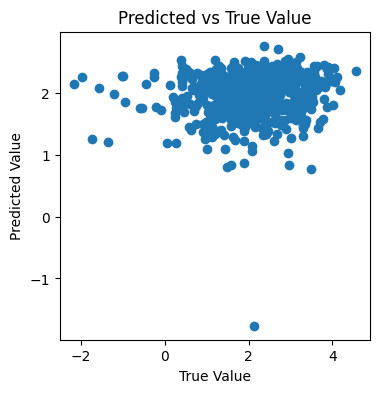

In [34]:
# make prediction 

y_pred = net.predict(feature_data_numpy)

# plot the output against the target

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 4))
plt.scatter(label_data_numpy, y_pred)
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Predicted vs True Value')
# plt.xlim(-2, 4)
# plt.ylim(0, 4)
plt.show()

In [35]:
# calculate pearson correlation

from scipy.stats import pearsonr

corr, _ = pearsonr(label_data_numpy.flatten(), y_pred.flatten())

print(f'Pearsons correlation: {corr}')

Pearsons correlation: 0.14310619537858338


### Integration with Powerkit

In [36]:
from toolkit import *   

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [37]:
powerkit = Powerkit(feature_data, label_data)
rngs = list(range(10))

def pipeline_func(X_train, y_train, rng, **kwargs):
    group_feat_size = 10
    total_feat_size = 260

    net = NeuralNetRegressor(
        TorchModel,
        module__group_feat_size=group_feat_size,
        module__total_feat_size=total_feat_size,
        optimizer=torch.optim.Adam,
        criterion=torch.nn.MSELoss,
        max_epochs=20,
        lr=0.001,
        batch_size=32,
        iterator_train__shuffle=True
    )
    
    x_train_numpy = X_train.to_numpy()
    y_train_numpy = y_train.to_numpy()
    y_train_numpy = y_train_numpy.reshape(-1, 1)
    net.fit(x_train_numpy, y_train_numpy)
    return {'model': net}


def eval_func(X_test, y_test, pipeline_components=None, **kwargs):
    
    # preprocess x and y 
    x_test_numpy = X_test.to_numpy()
    y_test_numpy = y_test.to_numpy()
    y_test_numpy = y_test_numpy.reshape(-1, 1)
    
    net = pipeline_components['model']
    y_pred = net.predict(x_test_numpy)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test_numpy.flatten(), y_pred.flatten())
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': None}

In [38]:
powerkit.add_condition('pytorch', False, pipeline_func, {}, eval_func, {})

In [39]:
powerkit.run_selected_condition('pytorch', rngs, n_jobs=1)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.3686        2.2308  0.0910
      2        1.5989        1.7191  0.0900
      3        1.4232        1.5617  0.0910
      4        1.3473        1.4113  0.1030
      5        1.3119        1.4172  0.0880
      6        1.2437        1.2961  0.0860
      7        1.2114        1.3042  0.0870
      8        1.2028        1.2970  0.0860
      9        1.1733        1.2545  0.0860
     10        1.1470        1.2088  0.0850
     11        1.1240        1.1575  0.0850
     12        1.1193        1.1860  0.0860
     13        1.0905        1.1783  0.0860
     14        1.0845        1.2427  0.0850
     15        1.0617        1.1540  0.0900
     16        1.0637        1.1673  0.0900
     17        1.0508        1.1278  0.0850
     18        1.0319        1.1048  0.0930
     19        1.0383        1.0852  0.1030
     20        1.0312        1.1162  0.0870
  epoch    train_loss    valid_l

,rng,condition,model_performance,p_vals
0,0,pytorch,0.141459,0.253515
1,1,pytorch,0.015951,0.898061
2,2,pytorch,0.077332,0.533935
3,3,pytorch,0.133526,0.281383
4,4,pytorch,0.024700,0.842729
5,5,pytorch,0.004248,0.972786
6,6,pytorch,0.000146,0.999064
7,7,pytorch,0.011788,0.924571
8,8,pytorch,-0.023552,0.849952
9,9,pytorch,-0.001878,0.987965
